<a href="https://colab.research.google.com/github/madhugraj/Abstractive-summarizor/blob/master/COMPAS_Recidivism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The COMPAS dataset consists of the results of a commercial algorithm called COMPAS (Correctional Offender Management Profiling for Alternative Sanctions), used to assess a convicted criminal's likelihood of reoffending. COMPAS has been used by judges and parole officers and is widely known for its bias against African-Americans.

In this notebook, we will use fairlens to explore the COMPAS dataset for bias toward legally protected features. We will go on to show similar biases in a logistic regressor trained to forecast a criminal's risk of reoffending using the dataset.

In [2]:
!pip install fairlens

     |████████████████████████████████| 38.1 MB 65.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
# Import libraries
import numpy as np
import pandas as pd
import fairlens as fl
import matplotlib.pyplot as plt
from itertools import combinations, chain
from sklearn.linear_model import LogisticRegression

# Load in the 2 year COMPAS Recidivism dataset
df = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")

In [6]:
df.head(5)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [7]:
df = df[(df["days_b_screening_arrest"] <= 30)
        & (df["days_b_screening_arrest"] >= -30)
        & (df["is_recid"] != -1)
        & (df["c_charge_degree"] != 'O')
        & (df["score_text"] != 'N/A')].reset_index(drop=True)

df.head(2)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1


**Analysis**


We'll begin by identifying the legally protected attributes in the data. fairlens detects these using using fuzzy matching on the column names and values to a custom preset of expected values.

In [8]:
# Detect sensitive attributes
sensitive_attributes = fl.sensitive.detect_names_df(df, deep_search=True)
print(sensitive_attributes)
print(sensitive_attributes.keys())

{'sex': 'Gender', 'dob': 'Age', 'age': 'Age', 'race': 'Ethnicity'}
dict_keys(['sex', 'dob', 'age', 'race'])


In [9]:
df[["sex", "race", "age", "dob", "age_cat", "decile_score"]].head()

,sex,race,age,dob,age_cat,decile_score
0,Male,Other,69,1947-04-18,Greater than 45,1
1,Male,African-American,34,1982-01-22,25 - 45,3
2,Male,African-American,24,1991-05-14,Less than 25,4
3,Male,Other,44,1971-08-22,25 - 45,1
4,Male,Caucasian,41,1974-07-23,25 - 45,6


**fairlens** will discretize continuous sensitive attributes such as age to make the results more interpretable, i.e. "Greater than 45", "25 - 45", "Less than 25" in the case of age. The COMPAS dataset comes with a categorical column for age which we can use instead.

We can inspect potential biases in decile scores by visualizing the distributions of different sensitive sub-groups in the data. Methods in fairlens.plot can be used to generate plots of distributions of variables in different sub-groups in the data.

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


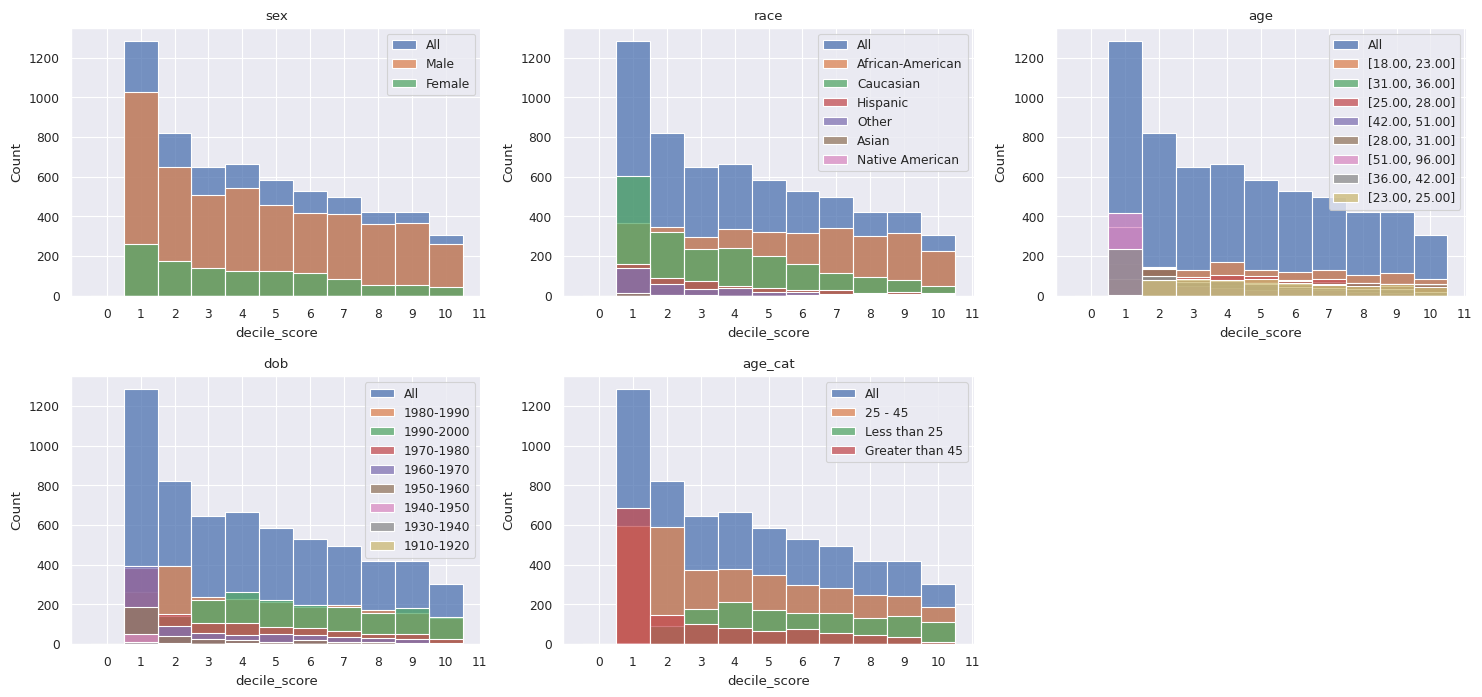

In [10]:
target_attribute = "decile_score"
sensitive_attributes = ["sex", "race", "age", "dob", "age_cat"]

# Set the seaborn style
fl.plot.use_style()

# Plot the distributions
fl.plot.mult_distr_plot(df, target_attribute, sensitive_attributes)
plt.show()

The largest horizontal disparity in scores seems to be in race, specifically between African-Americans and Caucasians, who make up most of the sample. We can visualize or measure the distance between two arbitrary sub-groups using predicates as shown below.

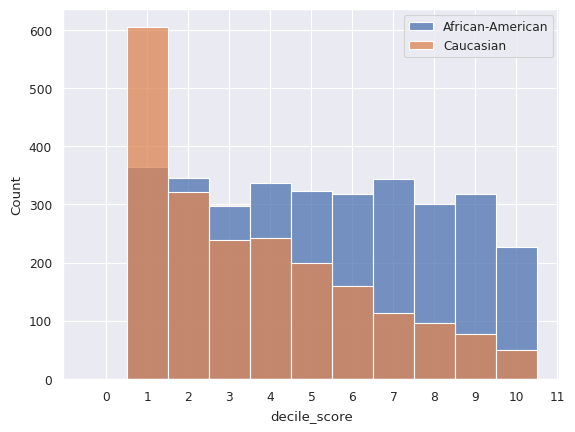

In [11]:
# Plot the distributions of decile scores in subgroups made of African-Americans and Caucasians
group1 = {"race": ["African-American"]}
group2 = {"race": ["Caucasian"]}

fl.plot.distr_plot(df, "decile_score", [group1, group2])
plt.legend(["African-American", "Caucasian"])
plt.show()

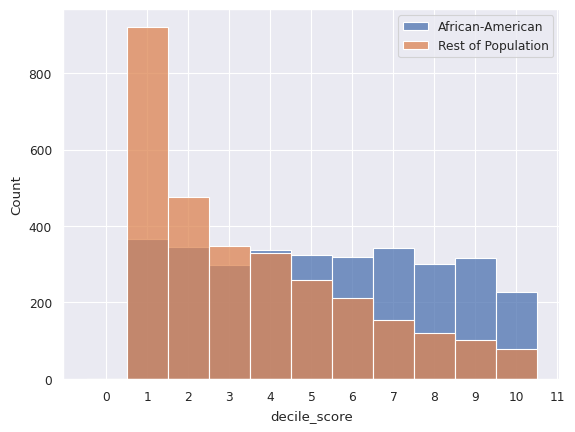

In [12]:
group1 = {"race": ["African-American"]}
group2 = df["race"] != "African-American"

fl.plot.distr_plot(df, "decile_score", [group1, group2])
plt.legend(["African-American", "Rest of Population"])
plt.show()

The above disparity by measuring statistical distances between the two distributions. Since the the decile scores are categorical, metrics such as the Earth Mover's Distance, the LP-Norm, or the Hellinger Distance would be useful. fairlens.metrics provides a stat_distance method which can be used to compute these metrics.

In [14]:
import fairlens.metrics as fm

group1 = {"race": ["African-American"]}
group2 = {"race": ["Caucasian"]}

distances = {}
for metric in ["emd", "norm", "hellinger"]:
    distances[metric] = fm.stat_distance(df, "decile_score", group1, group2, mode=metric)


pd.DataFrame.from_dict(distances, orient="index", columns=["distance"])

,distance
emd,0.245107
norm,0.210866
hellinger,0.214566


Measuring the statistical distance between the distribution of a variable in a subgroup and in the entire dataset can indicate how biased the variable is with respect to the subgroup. We can use the fl.FairnessScorer class to compute this for each sub-group.

In [15]:
fscorer = fl.FairnessScorer(df, "decile_score", ["sex", "race", "age_cat"])
fscorer.distribution_score(max_comb=1, p_value=True)

,Group,Distance,Proportion,Counts,P-Value
0,Greater than 45,0.322188,0.209494,1293,0.47
1,25 - 45,0.042123,0.572262,3532,0.97
2,Less than 25,0.272500,0.218244,1347,0.54
3,Other,0.253175,0.055574,343,0.66
4,African-American,0.130340,0.514420,3175,0.58
5,Caucasian,0.115572,0.340732,2103,0.66
6,Hispanic,0.184277,0.082469,509,0.44
7,Asian,0.331973,0.005023,31,0.82
8,Native American,0.492532,0.001782,11,0.88
9,Male,0.016210,0.809624,4997,0.94


The method fl.FairnessScorer.distribution_score() makes use of suitable hypothesis tests to determine how different the distribution of the decile scores is in each sensitive subgroup.

## Training a Model
Our above analysis has confirmed that there are inherent biases present in the COMPAS dataset. We now show the result of training a model on the COMPAS dataset and using it to predict an unknown criminal's likelihood of reoffending.

We use a logistic regressor trained on a subset of the features.

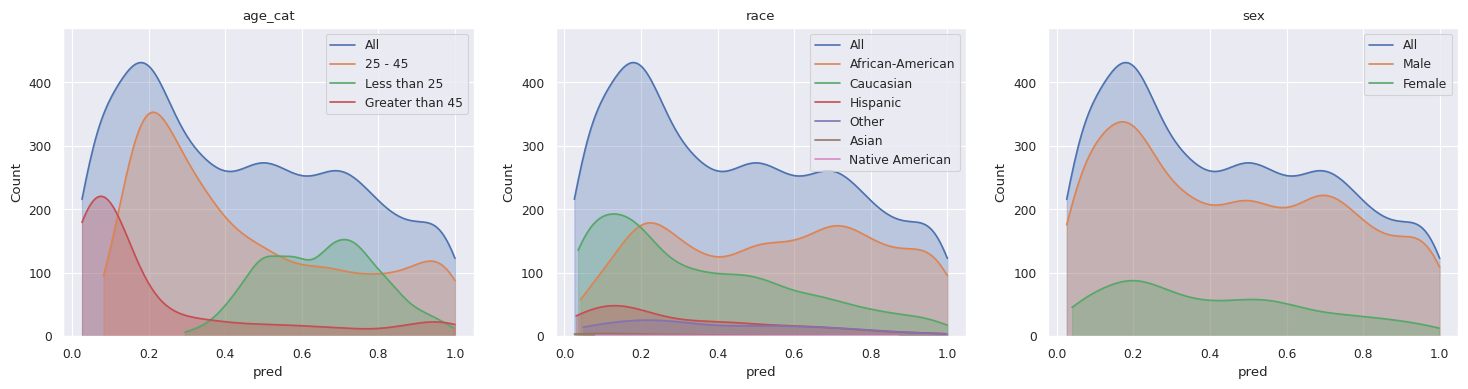

In [16]:
# Select the features to use
df = df[["sex", "race", "age_cat", "c_charge_degree", "priors_count", "two_year_recid", "score_text"]]

# Split the dataset into train and test
sp = int(len(df) * 0.8)
df_train = df[:sp].reset_index(drop=True)
df_test = df[sp:].reset_index(drop=True)

# Convert categorical columns to numerical columns
def preprocess(df):
    X = df.copy()
    X["sex"] = pd.factorize(df["sex"])[0]
    X["race"] = pd.factorize(df["race"])[0]
    X["age_cat"].replace(["Greater than 45", "25 - 45", "Less than 25"], [2, 1, 0], inplace=True)
    X["c_charge_degree"] = pd.factorize(df["c_charge_degree"])[0]
    X.drop(columns=["score_text"], inplace=True)
    X = X.to_numpy()

    y = pd.factorize(df["score_text"] != "Low")[0]

    return X, y

df_train = df[:sp].reset_index(drop=True)

# Train a regressor
X, y = preprocess(df_train)
clf = LogisticRegression(random_state=0).fit(X, y)

# Classify the training data
df_train["pred"] = clf.predict_proba(X)[:, 1]

# Plot the distributions
fscorer = fl.FairnessScorer(df_train, "pred", ["race", "sex", "age_cat"])
fscorer.plot_distributions()
plt.show()

In [17]:
X = df.copy()
X["sex"] = pd.factorize(df["sex"])[0]
X["race"] = pd.factorize(df["race"])[0]
X["age_cat"].replace(["Greater than 45", "25 - 45", "Less than 25"], [2, 1, 0], inplace=True)
X["c_charge_degree"] = pd.factorize(df["c_charge_degree"])[0]
X.drop(columns=["score_text"], inplace=True)

X.corr()

,sex,race,age_cat,c_charge_degree,priors_count,two_year_recid
sex,1.000000,0.025568,0.002701,0.061848,-0.118722,-0.100911
race,0.025568,1.000000,0.104551,0.078824,-0.123963,-0.088536
age_cat,0.002701,0.104551,1.000000,0.097368,0.169822,-0.156930
c_charge_degree,0.061848,0.078824,0.097368,1.000000,-0.145433,-0.120332
priors_count,-0.118722,-0.123963,0.169822,-0.145433,1.000000,0.290607
two_year_recid,-0.100911,-0.088536,-0.156930,-0.120332,0.290607,1.000000


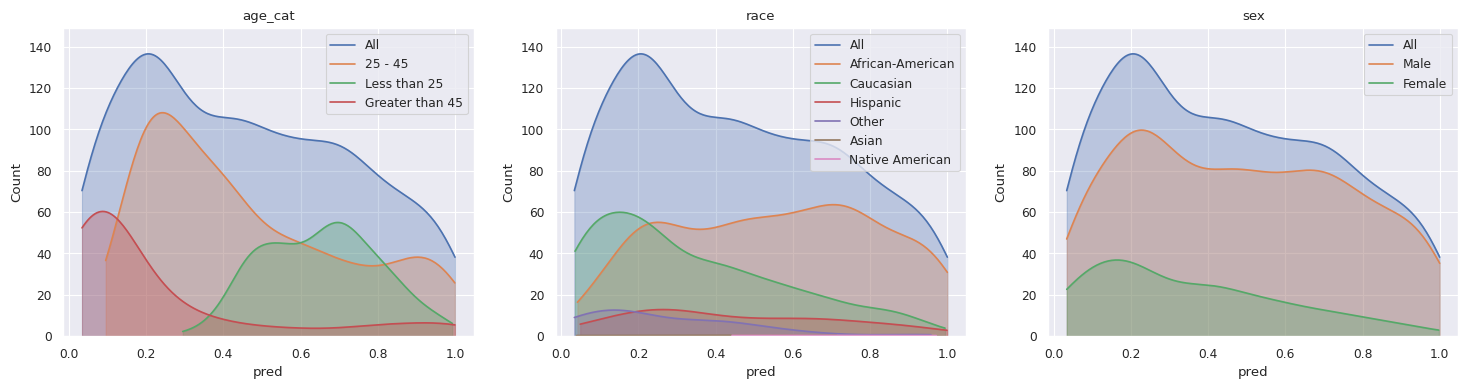

In [18]:
# Classify the test data
X, _ = preprocess(df_test)
df_test["pred"] = clf.predict_proba(X)[:, 1]

# Plot the distributions
fscorer = fl.FairnessScorer(df_test, "pred", ["race", "sex", "age_cat"])
fscorer.plot_distributions()
plt.show()

In [19]:
fscorer.distribution_score(max_comb=1, p_value=True).sort_values("Distance", ascending=False).reset_index(drop=True)

,Group,Distance,Proportion,Counts,P-Value
0,Native American,0.513360,0.002429,3,3.046032e-01
1,Greater than 45,0.495185,0.204858,253,7.771561e-16
2,Less than 25,0.456088,0.229150,283,3.005322e-44
3,Other,0.333459,0.059109,73,2.491168e-07
4,Asian,0.238664,0.003239,4,9.366481e-01
5,Caucasian,0.200244,0.324696,401,4.152367e-11
6,Female,0.175752,0.208907,258,3.079097e-06
7,African-American,0.166902,0.522267,645,8.779233e-11
8,25 - 45,0.117271,0.565992,699,8.242076e-06
9,Hispanic,0.082636,0.088259,109,4.743583e-01


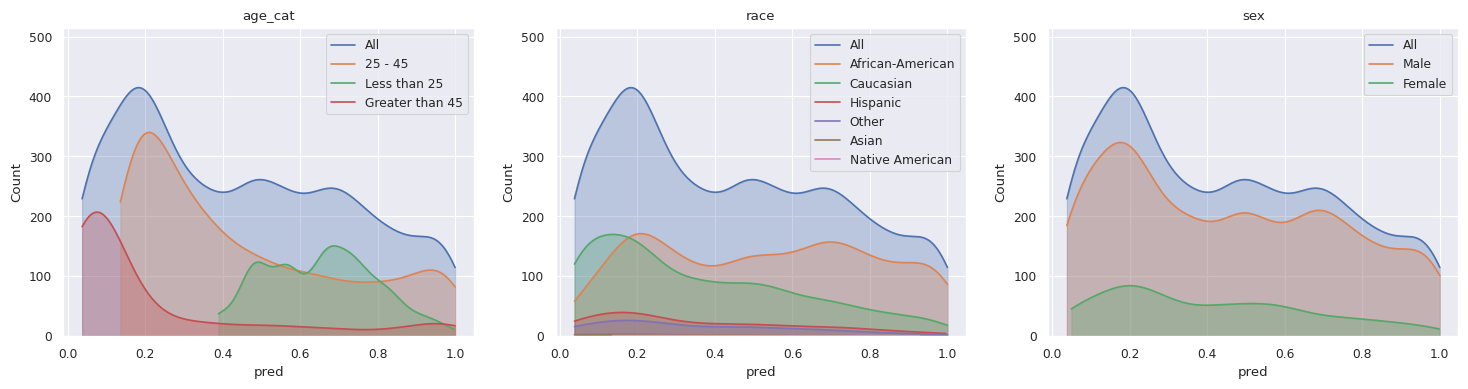

In [20]:
# Drop the predicted column before training again
df_train.drop(columns=["pred"], inplace=True)

# Preprocess he data and drop race
X, y = preprocess(df_train)
X = np.delete(X, df_train.columns.get_loc("race"), axis=1)

# Train a regressor and classify the training data
clf = LogisticRegression(random_state=0).fit(X, y)
df_train["pred"] = clf.predict_proba(X)[:, 1]

# Plot the distributions
fscorer = fl.FairnessScorer(df_train, "pred", ["race", "sex", "age_cat"])
fscorer.plot_distributions()
plt.show()

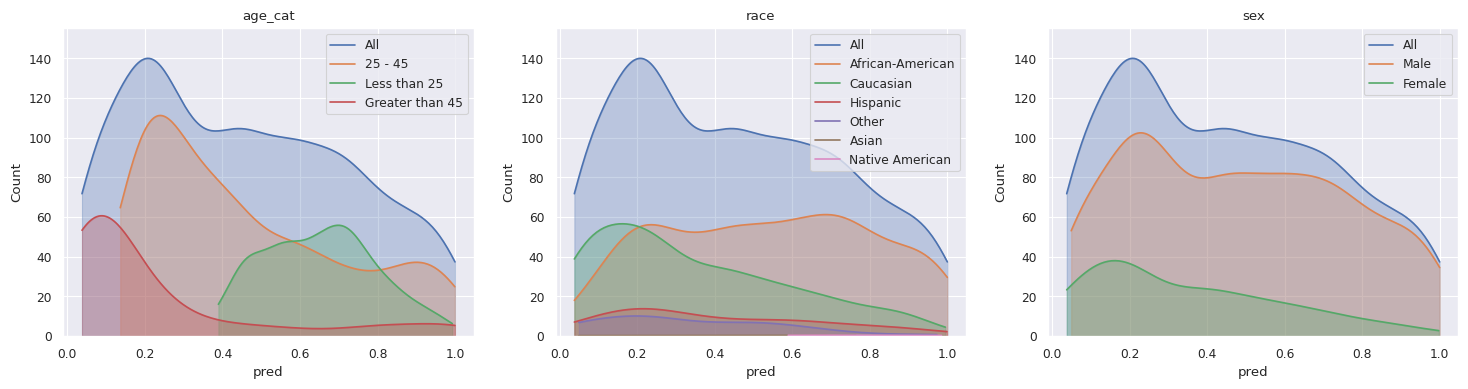

In [21]:
# Drop the predicted column before training again
df_test.drop(columns=["pred"], inplace=True)

# Classify the test data
X, _ = preprocess(df_test)
X = np.delete(X, df_test.columns.get_loc("race"), axis=1)

df_test["pred"] = clf.predict_proba(X)[:, 1]

# Plot the distributions
fscorer = fl.FairnessScorer(df_test, "pred", ["race", "sex", "age_cat"])
fscorer.plot_distributions()
plt.show()

In [22]:
fscorer.distribution_score(max_comb=1, p_value=True).sort_values("Distance", ascending=False).reset_index(drop=True)

,Group,Distance,Proportion,Counts,P-Value
0,Native American,0.672065,0.002429,3,7.123637e-02
1,Greater than 45,0.503900,0.204858,253,7.771561e-16
2,Less than 25,0.488846,0.229150,283,3.438215e-51
3,Asian,0.243927,0.003239,4,9.240617e-01
4,Other,0.211059,0.059109,73,3.564472e-03
5,Female,0.173141,0.208907,258,4.565218e-06
6,Caucasian,0.160895,0.324696,401,2.577566e-07
7,African-American,0.128776,0.522267,645,1.368363e-06
8,25 - 45,0.120753,0.565992,699,3.908314e-06
9,Hispanic,0.097017,0.088259,109,2.824348e-01
